In [1]:
%config Completer.use_jedi=False
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


In [2]:
#import lnPi.old
import lnPi

import lnPi.stability
import lnPi.monoutils

import lnPi2

In [3]:
#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# create a reference lnPi_phases for bulk case

In [4]:
pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

In [5]:
mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu


In [6]:
# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', 
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases

In [7]:
# create a phase object
p = PhaseCreator.build_phases()
p.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   beta * Omega(lnz,V,beta)

In [8]:
# old
# reference masked lnPi
ref0 = lnPi2.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', 
                                      mu=mu, state_kws=state_kws, extra_kws={'pe':pe}).zeromax()

# Phase Creator
PhaseCreator0 = lnPi2.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref0)
build_phases0 = PhaseCreator0.build_phases

p0 = PhaseCreator0.build_phases()
p0.xgce.omega().pipe(lambda x: x*x.beta)

<xarray.DataArray (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    mu_0     float64 -8.616
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1

## create a collection

In [9]:
lnzs = np.geomspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 20)
mus = lnzs / beta

In [10]:
# new
# initial pass
c = lnPi.CollectionPhases.from_lnz([None], lnzs, build_phases=PhaseCreator.build_phases)
c0 = lnPi2.CollectionPhases.from_mu([None], mus,  build_phases=PhaseCreator0.build_phases)

In [11]:
spin, _ = c.spinodals(2, build_phases=build_phases, as_dict=False)
bino, _ = c.binodals(2, spinodals=spin, build_phases=build_phases, as_dict=False)

In [23]:
(
    bino
    .xgce_props
    .table(props_keys=['mu'])
    .assign(ntot=lambda x: x['nave'].sum(x['nave'].dims_comp))
    .assign(dens=lambda x: x['nave'] / x['volume'])
    .assign(PE_n=lambda x: x['PE'] / x['ntot'])
    .pipe(lnPi.xlnPi.dim_to_suffix_dataset, 'component').to_dataframe()
    
#     .assign(mu=lambda x: x['lnz_0'] * x['beta'])
#     .assign(pressure=lambda x: x['betapV'] / x['beta'] / x['volume'])
#     .assign(dens=lambda x: x['nave_0'] / x['volume'])
#     .assign(PE_n=lambda x: x['PE'] / x[''])
)

,,lnz_0,volume,temp,beta,betapV,PE,ntot,PE_n,nave_0,mu_0,dens_0
phase,rec,,,,,,,,,,,
0,0,-12.339048,729,0.7,1.428571,2.475048,-0.104744,2.557705,-0.040952,2.557705,-17.627212,0.003509
1,0,-12.339048,729,0.7,1.428571,2.475048,-3335.310652,597.939083,-5.578011,597.939083,-17.627212,0.820218


In [15]:
pd.read_csv('./binodal.csv')

,component,phase,beta,volume,temp,mu_0,density,pressure,energy,lnz
0,0,0,0.833333,512.0,1.20,-3.636708,0.100375,0.077234,-0.855508,-3.030590
1,0,1,0.833333,512.0,1.20,-3.636708,0.563140,0.077234,-3.871047,-3.030590
2,0,0,1.333333,512.0,0.75,-4.262522,0.003630,0.002636,-0.042503,-5.683363
3,0,1,1.333333,512.0,0.75,-4.262522,0.821441,0.002636,-5.905438,-5.683363
4,0,0,1.250000,512.0,0.80,-4.156566,0.006103,0.004647,-0.067583,-5.195707
5,0,1,1.250000,512.0,0.80,-4.156566,0.799605,0.004647,-5.713926,-5.195707
6,0,0,0.909091,512.0,1.10,-3.722601,0.055064,0.046019,-0.493164,-3.384183
7,0,1,0.909091,512.0,1.10,-3.722601,0.640863,0.046019,-4.431399,-3.384183
8,0,0,1.000000,512.0,1.00,-3.834421,0.029566,0.024953,-0.280554,-3.834421
9,0,1,1.000000,512.0,1.00,-3.834421,0.701151,0.024953,-4.896128,-3.834421


In [89]:
def dim_to_suffix_dataarray(da, dim, join='_'):
    if dim in da.dims:
        return (
            da
            .assign_coords(**{dim : lambda x: ['{}{}{}'.format(x.name, join, c) for c in x[dim].values]})
            .to_dataset(dim=dim)
        )
    else:
        return da.to_dataset()

def dim_to_suffix_dataset(table, dim, join='_'):
    out = table
    for k in out:
        if dim in out[k].dims:
            out = (
                out
                .drop(k)
                .update(table[k].pipe(dim_to_suffix_dataarray, dim, join))
            )
    return out
                
        
    

    

In [103]:
c.xgce.molfrac().pipe(dim_to_suffix_dataarray, 'component')

<xarray.Dataset>
Dimensions:    (phase: 2, rec: 20)
Coordinates:
  * phase      (phase) int64 0 1
    lnz_0      (rec) float64 -17.31 -16.54 -15.81 ... -8.003 -7.648 -7.309
    volume     (rec) int64 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp       (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta       (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec        (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    molfrac_0  (rec, phase) float64 1.0 nan 1.0 nan 1.0 ... 1.0 nan 1.0 nan 1.0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   mole_fraction(component,lnz,V,beta)

In [92]:
dim_to_suffix_dataarray(c.xgce., 'component')

<xarray.Dataset>
Dimensions:  (phase: 2, rec: 20)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -16.54 -15.81 -15.11 ... -8.003 -7.648 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    nave_0   (rec, phase) float64 0.01666 nan 0.03593 nan ... 659.9 nan 659.9
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   <n(component,lnz,V,beta)>

In [87]:
table = c.xgce_props.table(xgce_keys=['nvar'])
table

<xarray.Dataset>
Dimensions:  (component: 1, phase: 2, rec: 20)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -16.54 -15.81 -15.11 ... -8.003 -7.648 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: component
Data variables:
    nvar     (rec, phase, component) float64 0.01667 nan 0.03596 ... nan 0.1106
    nave     (rec, phase, component) float64 0.01666 nan 0.03593 ... nan 659.9
    betapV   (rec, phase) float64 0.01666 nan 0.03591 ... nan 3.245e+03
    PE       (rec, phase) float64 -4.356e-06 nan -2.04e-05 ... nan -3.989e+03

In [55]:
out = []
for x in table:
    if 'component' in table[x].dims:
        out 
        

nave
betapV
PE


In [53]:
for x in table.keys():
    break

In [54]:
x

'nave'

In [44]:
spin.xgce.nave().pipe(dimension_suffix, 'component')

<xarray.Dataset>
Dimensions:  (phase: 2, rec: 2)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -10.67 -13.7
    volume   (rec) int64 729 729
    temp     (rec) float64 0.7 0.7
    beta     (rec) float64 1.429 1.429
  * rec      (rec) int64 0 1
Data variables:
    nave_0   (rec, phase) float64 23.57 640.4 0.6261 523.7
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   <n(component,lnz,V,beta)>

In [38]:
(
    spin.xgce.nave()
    .assign_coords(component=lambda x: ['{}_{}'.format(x.name, c) for c in x['component'].values] )
    .to_dataset(dim='component')
)

<xarray.Dataset>
Dimensions:  (phase: 2, rec: 2)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -10.67 -13.7
    volume   (rec) int64 729 729
    temp     (rec) float64 0.7 0.7
    beta     (rec) float64 1.429 1.429
  * rec      (rec) int64 0 1
Data variables:
    nave_0   (rec, phase) float64 23.57 640.4 0.6261 523.7
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   <n(component,lnz,V,beta)>

In [111]:
c.spinodals(2, inplace=True, append=False, build_phases=build_phases)

In [51]:
spin, _ = c.spinodals(2, inplace=False, append=False, build_phases=PhaseCreator.build_phases)

In [55]:
spin_, _ = c.spinodals(2, inplace=False, append=False, build_phases=build_phases, as_dict=False)

In [104]:
xr.concat((spin[0].xgce.nave(), spin[1].xgce.nave()), dim=xx.index, coords='different')

<xarray.DataArray 'nave' (concat_dim: 2, phase: 2, component: 1)>
array([[[2.357318e+01],
        [6.404177e+02]],

       [[6.260992e-01],
        [5.236544e+02]]])
Coordinates:
    volume      int64 729
    temp        float64 0.7
    beta        float64 1.429
  * phase       (phase) int64 0 1
    lnz_0       (concat_dim) float64 -10.67 -13.7
  * concat_dim  (concat_dim) MultiIndex
  - a           (concat_dim) int64 0 1
  - b           (concat_dim) int64 1 0
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   <n(component,lnz,V,beta)>

In [102]:
xx = lnPi.CollectionPhases(spin.values(), index=[(0,1),(1,0)], concat_dim=['a','b'])

In [109]:
xx.index.rename()

TypeError: Must pass list-like as `names`.

In [107]:
pd.Index([(0,1),(1,0)], name=['a','b'])

MultiIndex([(0, 1),
            (1, 0)],
           names=['a', 'b'])

In [80]:
c.binodals(2, inplace=False, append=False, build_phases=build_phases, spinodals=spin_)

({0: <Phases  (phase : 2)>
  index Int64Index([0, 1], dtype='int64', name='phase')},
 {0:       converged: True
             flag: 'converged'
   function_calls: 8
       iterations: 7
             root: -12.339048403357351})

In [13]:
spin2, _ = c2.spinodals(2, inplace=False, append=False, build_phases=PhaseCreator2.build_phases)

In [14]:
bino, _ = c.binodals(2, spinodals=spin, inplace=False, append=False, build_phases=PhaseCreator.build_phases)

In [15]:
bino2, _ = c2.binodals(2, spinodals=spin2, inplace=False, append=False, build_phases=PhaseCreator2.build_phases)

In [16]:
bino[0].xgce.density

<xarray.DataArray 'density' (phase: 2, component: 1)>
array([[0.003509],
       [0.820218]])
Coordinates:
    mu_0     float64 -8.637
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,mu,V,T)

In [ ]:
ref.xcan.

In [25]:
c2.xgce.pipe(lambda x: (x.pi_norm * (ref2.xcan.betaF() + x.lnpi_norm)).sum(x.dims_n))

<xarray.DataArray (rec: 20, phase: 2)>
array([[-3.996632e-02,           nan],
       [-1.387970e-01,           nan],
       [-4.414880e-01,           nan],
       [-1.294636e+00,           nan],
       [-3.524629e+00,           nan],
       [-8.986582e+00,           nan],
       [-2.174197e+01, -7.173499e+03],
       [-5.118690e+01, -7.529222e+03],
       [-1.261592e+02, -7.764683e+03],
       [          nan, -7.934251e+03],
       [          nan, -8.039437e+03],
       [          nan, -8.061334e+03],
       [          nan, -8.066034e+03],
       [          nan, -8.067578e+03],
       [          nan, -8.068217e+03],
       [          nan, -8.068517e+03],
       [          nan, -8.068670e+03],
       [          nan, -8.068752e+03],
       [          nan, -8.068799e+03],
       [          nan, -8.068826e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729 729 ...

In [21]:
c2.xgce_fe.betaF()

<xarray.DataArray 'betaF' (rec: 20, phase: 2)>
array([[-3.996632e-02,           nan],
       [-1.387970e-01,           nan],
       [-4.414880e-01,           nan],
       [-1.294636e+00,           nan],
       [-3.524629e+00,           nan],
       [-8.986582e+00,           nan],
       [-2.174197e+01, -7.173499e+03],
       [-5.118690e+01, -7.529222e+03],
       [-1.261592e+02, -7.764683e+03],
       [          nan, -7.934251e+03],
       [          nan, -8.039437e+03],
       [          nan, -8.061334e+03],
       [          nan, -8.066034e+03],
       [          nan, -8.067578e+03],
       [          nan, -8.068217e+03],
       [          nan, -8.068517e+03],
       [          nan, -8.068670e+03],
       [          nan, -8.068752e+03],
       [          nan, -8.068799e+03],
       [          nan, -8.068826e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729

In [18]:
bino2[0].xgce.density()

<xarray.DataArray 'density' (phase: 2, component: 1)>
array([[0.003509],
       [0.820218]])
Coordinates:
    lnz_0    float64 -12.34
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,lnz,V,beta)

In [38]:
c2.xgce.betag

<xarray.DataArray 'betag' (rec: 20, phase: 2)>
array([[-19.451429,        nan],
       [-18.140328,        nan],
       [-16.9176  ,        nan],
       [-15.777289,        nan],
       [-14.713839,        nan],
       [-13.72207 ,        nan],
       [-12.79715 , -12.79715 ],
       [-11.934573, -11.934573],
       [-11.130137, -11.130137],
       [       nan, -10.379923],
       [       nan,  -9.680276],
       [       nan,  -9.027789],
       [       nan,  -8.419281],
       [       nan,  -7.851789],
       [       nan,  -7.322548],
       [       nan,  -6.828981],
       [       nan,  -6.368681],
       [       nan,  -5.939408],
       [       nan,  -5.539069],
       [       nan,  -5.165714]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec 

In [37]:
(c.xgce.mu.pipe(lambda x: x * x.beta) * c.xgce.molfrac).sum('component')

<xarray.DataArray (rec: 20, phase: 2)>
array([[-19.451429,   0.      ],
       [-18.140328,   0.      ],
       [-16.9176  ,   0.      ],
       [-15.777289,   0.      ],
       [-14.713839,   0.      ],
       [-13.72207 ,   0.      ],
       [-12.79715 , -12.79715 ],
       [-11.934573, -11.934573],
       [-11.130137, -11.130137],
       [  0.      , -10.379923],
       [  0.      ,  -9.680276],
       [  0.      ,  -9.027789],
       [  0.      ,  -8.419281],
       [  0.      ,  -7.851789],
       [  0.      ,  -7.322548],
       [  0.      ,  -6.828981],
       [  0.      ,  -6.368681],
       [  0.      ,  -5.939408],
       [  0.      ,  -5.539069],
       [  0.      ,  -5.165714]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec

In [29]:
(c.xgce.mu * c.xgce.nave).sum('component')

<xarray.DataArray (rec: 20, phase: 2)>
array([[-2.660851e-02,  0.000000e+00],
       [-9.208226e-02,  0.000000e+00],
       [-2.917987e-01,  0.000000e+00],
       [-8.522784e-01,  0.000000e+00],
       [-2.310644e+00,  0.000000e+00],
       [-5.866379e+00,  0.000000e+00],
       [-1.413669e+01, -5.208916e+03],
       [-3.318975e+01, -5.097647e+03],
       [-8.194951e+01, -4.912903e+03],
       [ 0.000000e+00, -4.696254e+03],
       [ 0.000000e+00, -4.450395e+03],
       [ 0.000000e+00, -4.165082e+03],
       [ 0.000000e+00, -3.887495e+03],
       [ 0.000000e+00, -3.626501e+03],
       [ 0.000000e+00, -3.382491e+03],
       [ 0.000000e+00, -3.154700e+03],
       [ 0.000000e+00, -2.942164e+03],
       [ 0.000000e+00, -2.743906e+03],
       [ 0.000000e+00, -2.558988e+03],
       [ 0.000000e+00, -2.386520e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 729 ... 

In [24]:
bino2[0].xgce.density.assign_coords(mu_0=lambda x: x['lnz_0'] / x['beta'])

<xarray.DataArray 'density' (phase: 2, component: 1)>
array([[0.003509],
       [0.820218]])
Coordinates:
    lnz_0    float64 -12.34
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0 1
    mu_0     float64 -8.637
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,lnz,V,beta)

In [50]:
spin[0].xgce.density

<xarray.DataArray 'density' (phase: 2, component: 1)>
array([[0.032336],
       [0.878488]])
Coordinates:
    mu_0     float64 -7.468
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,mu,V,T)

In [52]:
spin2[0].xgce.density.assign_coords(mu_0=lambda x: x['lnz_0'] / x['betai'])

<xarray.DataArray 'density' (phase: 2, component: 1)>
array([[0.032336],
       [0.878488]])
Coordinates:
    lnz_0    float64 -10.67
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0 1
    mu_0     float64 -7.468
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,lnz,V,beta)

In [ ]:
c.binodals(2, )

In [39]:
c.xgce.omega().pipe(lambda x: x * x.beta) / c.xgce.nave.sum('component') 

<xarray.DataArray (rec: 20, phase: 2)>
array([[-0.999975,       nan],
       [-0.999909,       nan],
       [-0.99969 ,       nan],
       [-0.99903 ,       nan],
       [-0.997179,       nan],
       [-0.992315,       nan],
       [-0.980101,  0.460563],
       [-0.949693, -0.404578],
       [-0.864055, -1.183436],
       [      nan, -1.895784],
       [      nan, -2.560611],
       [      nan, -3.203235],
       [      nan, -3.808941],
       [      nan, -4.375272],
       [      nan, -4.903927],
       [      nan, -5.397166],
       [      nan, -5.857269],
       [      nan, -6.28642 ],
       [      nan, -6.68668 ],
       [      nan, -7.059982]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

In [35]:
c2.xgce.betaomega()

<xarray.DataArray 'betaomega' (rec: 20, phase: 2)>
array([[-0.999975,       nan],
       [-0.999909,       nan],
       [-0.99969 ,       nan],
       [-0.99903 ,       nan],
       [-0.997179,       nan],
       [-0.992315,       nan],
       [-0.980101,  0.460563],
       [-0.949693, -0.404578],
       [-0.864055, -1.183436],
       [      nan, -1.895784],
       [      nan, -2.560611],
       [      nan, -3.203235],
       [      nan, -3.808941],
       [      nan, -4.375272],
       [      nan, -4.903927],
       [      nan, -5.397166],
       [      nan, -5.857269],
       [      nan, -6.28642 ],
       [      nan, -6.68668 ],
       [      nan, -7.059982]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9

In [30]:
c.xgce.pressure().pipe(lambda x: x * x.beta) / c.xgce.density.sum('component')

<xarray.DataArray (rec: 20, phase: 2)>
array([[ 0.999975,       nan],
       [ 0.999909,       nan],
       [ 0.99969 ,       nan],
       [ 0.99903 ,       nan],
       [ 0.997179,       nan],
       [ 0.992315,       nan],
       [ 0.980101, -0.460563],
       [ 0.949693,  0.404578],
       [ 0.864055,  1.183436],
       [      nan,  1.895784],
       [      nan,  2.560611],
       [      nan,  3.203235],
       [      nan,  3.808941],
       [      nan,  4.375272],
       [      nan,  4.903927],
       [      nan,  5.397166],
       [      nan,  5.857269],
       [      nan,  6.28642 ],
       [      nan,  6.68668 ],
       [      nan,  7.059982]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

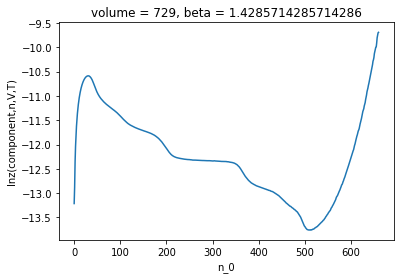

In [27]:
ref2.xcan.lnz.plot()

In [ ]:
c.xgce.

In [16]:
c2.xgce.betape.pipe(lambda x: x / x.beta)

<xarray.DataArray (rec: 20, phase: 2)>
array([[-1.044694e-05,           nan],
       [-1.092717e-04,           nan],
       [-3.884569e-04,           nan],
       [-1.221399e-03,           nan],
       [-3.553975e-03,           nan],
       [-9.690283e-03,           nan],
       [-2.514647e-02, -5.436608e+00],
       [-6.409743e-02, -5.679545e+00],
       [-1.779502e-01, -5.839487e+00],
       [          nan, -5.954106e+00],
       [          nan, -6.024588e+00],
       [          nan, -6.039652e+00],
       [          nan, -6.043155e+00],
       [          nan, -6.044424e+00],
       [          nan, -6.044999e+00],
       [          nan, -6.045293e+00],
       [          nan, -6.045454e+00],
       [          nan, -6.045548e+00],
       [          nan, -6.045605e+00],
       [          nan, -6.045640e+00]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729 729 ...

In [14]:
c.xgce.pe_n

<xarray.DataArray 'pe_n' (rec: 20, phase: 2)>
array([[-1.044694e-05,           nan],
       [-1.092717e-04,           nan],
       [-3.884569e-04,           nan],
       [-1.221399e-03,           nan],
       [-3.553975e-03,           nan],
       [-9.690283e-03,           nan],
       [-2.514647e-02, -5.436608e+00],
       [-6.409743e-02, -5.679545e+00],
       [-1.779502e-01, -5.839487e+00],
       [          nan, -5.954106e+00],
       [          nan, -6.024588e+00],
       [          nan, -6.039652e+00],
       [          nan, -6.043155e+00],
       [          nan, -6.044424e+00],
       [          nan, -6.044999e+00],
       [          nan, -6.045293e+00],
       [          nan, -6.045454e+00],
       [          nan, -6.045548e+00],
       [          nan, -6.045605e+00],
       [          nan, -6.045640e+00]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 7

In [18]:
c2.xgce.betaOmega().pipe(lambda x: x / x.beta)

<xarray.DataArray (rec: 20, phase: 2)>
array([[-1.367913e-03,           nan],
       [-5.075645e-03,           nan],
       [-1.724289e-02,           nan],
       [-5.396691e-02,           nan],
       [-1.565958e-01,           nan],
       [-4.242285e-01,           nan],
       [-1.082693e+00,  1.874664e+02],
       [-2.641073e+00, -1.728083e+02],
       [-6.361906e+00, -5.223750e+02],
       [          nan, -8.577216e+02],
       [          nan, -1.177211e+03],
       [          nan, -1.477852e+03],
       [          nan, -1.758729e+03],
       [          nan, -2.020804e+03],
       [          nan, -2.265261e+03],
       [          nan, -2.493262e+03],
       [          nan, -2.705905e+03],
       [          nan, -2.904220e+03],
       [          nan, -3.089171e+03],
       [          nan, -3.261658e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 729 729 ...

In [30]:
c2[0].xgce.betape()

TypeError: unsupported operand type(s) for /: 'method' and 'float'

In [28]:
c2.xgce.betaPE

<xarray.DataArray 'betaPE' (rec: 20, phase: 2)>
array([[-2.916502e-08,           nan],
       [-1.131990e-06,           nan],
       [-1.367387e-05,           nan],
       [-1.346514e-04,           nan],
       [-1.139005e-03,           nan],
       [-8.454556e-03,           nan],
       [-5.669117e-02, -4.516126e+03],
       [-3.637824e-01, -4.950857e+03],
       [-2.673919e+00, -5.260370e+03],
       [          nan, -5.497661e+03],
       [          nan, -5.652519e+03],
       [          nan, -5.686670e+03],
       [          nan, -5.694590e+03],
       [          nan, -5.697417e+03],
       [          nan, -5.698683e+03],
       [          nan, -5.699325e+03],
       [          nan, -5.699677e+03],
       [          nan, -5.699881e+03],
       [          nan, -5.700004e+03],
       [          nan, -5.700081e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -19.45 -18.14 -16.92 -15.78 ... -5.939 -5.539 -5.166
    volume   (rec) int64 729 729 729 729 729 72

In [22]:
c.xgce.pe_n.pipe(lambda x: x *x.beta)

<xarray.DataArray (rec: 20, phase: 2)>
array([[-1.492421e-05,           nan],
       [-1.561024e-04,           nan],
       [-5.549384e-04,           nan],
       [-1.744856e-03,           nan],
       [-5.077107e-03,           nan],
       [-1.384326e-02,           nan],
       [-3.592353e-02, -7.766583e+00],
       [-9.156775e-02, -8.113636e+00],
       [-2.542145e-01, -8.342125e+00],
       [          nan, -8.505865e+00],
       [          nan, -8.606554e+00],
       [          nan, -8.628074e+00],
       [          nan, -8.633079e+00],
       [          nan, -8.634892e+00],
       [          nan, -8.635713e+00],
       [          nan, -8.636132e+00],
       [          nan, -8.636363e+00],
       [          nan, -8.636497e+00],
       [          nan, -8.636578e+00],
       [          nan, -8.636629e+00]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -13.62 -12.7 -11.84 -11.04 ... -4.158 -3.877 -3.616
    volume   (rec) int64 729 729 729 729 729 729 729 ... 

In [51]:
%timeit -n 1 -r 1 c.xgce.density

95.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [52]:
p.xgce.density

<xarray.DataArray 'density' (phase: 1, component: 1)>
array([[2.680671e-06]])
Coordinates:
    mu_0     float64 -13.62
    volume   int64 729
    beta     float64 1.429
  * phase    (phase) int64 0
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,mu,V,T)

In [64]:
c.xgce

<xarray.DataArray 'density' (rec: 100, phase: 2, component: 1)>
array([[[2.680671e-06],
        [         nan]],

       [[3.472421e-06],
        [         nan]],

       [[4.482579e-06],
        [         nan]],

       [[5.767007e-06],
        [         nan]],

       [[7.394694e-06],
        [         nan]],

       [[9.450551e-06],
        [         nan]],

       [[1.203875e-05],
        [         nan]],

       [[1.528665e-05],
        [         nan]],

       [[1.934952e-05],
        [         nan]],

       [[2.441602e-05],
        [         nan]],

       [[3.071470e-05],
        [         nan]],

       [[3.852159e-05],
        [         nan]],

       [[4.816918e-05],
        [         nan]],

       [[6.005674e-05],
        [         nan]],

       [[7.466256e-05],
        [         nan]],

       [[9.255800e-05],
        [         nan]],

       [[1.144240e-04],
        [         nan]],

       [[1.410703e-04],
        [         nan]],

       [[1.734575e-04],
        [   

In [62]:
%timeit -n 1 -r 1 c.xgce.density

178 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
ref.xgce.pi

AttributeError: 'numpy.float64' object has no attribute 'rename'

In [24]:
ref.xgce.density

AttributeError: 'numpy.float64' object has no attribute 'rename'

In [23]:
%timeit -n 1 -r 1 c.xgce.density

AttributeError: no attribute density found

In [40]:
%%timeit -n 3 -r 3
c.xgce._cache = {}
c.xgce.density

55 ms ± 5.23 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [35]:
%%timeit -n 3 -r 3
ref.xgce._cache = {}
ref.xgce.pi


125 µs ± 22.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
L = []
for p in c:
    for x in p:
        L.append(x.xgce.density)
          

[MaskedlnPi(
      mu=array([-13.616])
      state_kws={'volume': 729, 'beta': 1.4285714285714286}
      extra_kws={'pe': array([ 4.00372530e-08,  4.00315170e-08, -3.08827170e-02, ...,
        -3.96941738e+03, -3.97945148e+03, -3.99017378e+03])}
      data=masked_array(data=[-18.06161029539, -24.29942903824714,
                    -31.20556188110428, ..., -4767.631953628388,
                    -4777.371562771245, -4787.133050914103],
              mask=[False, False, False, ..., False, False, False],
        fill_value=nan)
 ), MaskedlnPi(
      mu=array([-13.59794077])
      state_kws={'volume': 729, 'beta': 1.4285714285714286}
      extra_kws={'pe': array([ 4.00372530e-08,  4.00315170e-08, -3.08827170e-02, ...,
        -3.96941738e+03, -3.97945148e+03, -3.99017378e+03])}
      data=masked_array(data=[-18.06161029539, -24.273630141942245,
                    -31.15396408849449, ..., -4750.656279859768,
                    -4760.370090106321, -4770.105779352872],
              mask=[F

In [8]:
# mu min/max

In [9]:
reload(lnPi.monoutils)

<module 'lnPi.monoutils' from '/Users/wpk/Documents/python/lnPi/monoutils.py'>

In [10]:
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c, PhaseCreator.build_phases)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=ref, threshold_abs=1e-4, C=c, build_phases=PhaseCreator.build_phases)

In [11]:
c = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), 
                                  build_phases=PhaseCreator.build_phases)
c.spinodals([0,1], build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))
c.binodals([0,1], build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))
c.sort_by_mu()

In [149]:
xx = np.ma.array([1,2,3])

In [152]:
%psource xx.__repr__

In [154]:
ref

MaskedlnPi(
     data=array([-1.80616103e+01, -1.71565719e+01, -1.69198476e+01, -1.70637165e+01,
       -1.74704027e+01, -1.80750106e+01, -1.88368841e+01, -1.97280741e+01,
       -2.07278385e+01, -2.18209366e+01, -2.29936916e+01, -2.42359998e+01,
       -2.55399163e+01, -2.68979013e+01, -2.83040303e+01, -2.97525683e+01,
       -3.12407623e+01, -3.27628343e+01, -3.43157913e+01, -3.58968853e+01,
       -3.75017173e+01, -3.91293323e+01, -4.07755303e+01, -4.24384293e+01,
       -4.41166313e+01, -4.58071703e+01, -4.75078503e+01, -4.92168983e+01,
       -5.09325973e+01, -5.26530243e+01, -5.43759113e+01, -5.60996473e+01,
       -5.78225723e+01, -5.95419703e+01, -6.12555133e+01, -6.29603213e+01,
       -6.46550143e+01, -6.63370813e+01, -6.80033343e+01, -6.96528953e+01,
       -7.12826143e+01, -7.28895493e+01, -7.44720763e+01, -7.60303163e+01,
       -7.75627583e+01, -7.90689543e+01, -8.05505103e+01, -8.20070803e+01,
       -8.34392963e+01, -8.48492033e+01, -8.62385083e+01, -8.76078723e+01,
   

In [153]:
repr(xx)

'masked_array(data=[1, 2, 3],\n             mask=False,\n       fill_value=999999)'

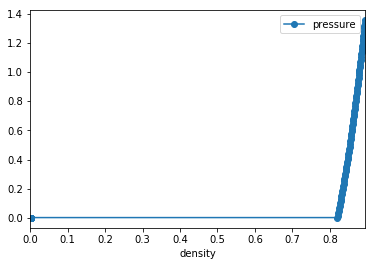

In [14]:
dens = c.xgce.density
pres = c.xgce.pressure()

# mask values
mask = pres.pipe(lambda x: x.max('phase') == x)

df = (
    xr.merge((dens, pres))
    .where(mask).max('phase')
    .to_dataframe()
)
    

df.plot('density','pressure',marker='o')

In [15]:
import xarray as xr
@xr.register_dataarray_accessor('lwhere')
def lwhere(da):
    def where(condition, drop=False):
        return da.where(condition(da), drop=drop)
    return where

In [16]:
# check for any bad positions
(
    c.xgce.edge_distance(ref).min('phase')
    .lwhere(lambda x: x < 10, drop=True)
)

<xarray.DataArray 'edge_distance' (rec: 0)>
array([], dtype=float64)
Coordinates:
    mu_0     (rec) float64 
    volume   (rec) int64 
    beta     (rec) float64 
  * rec      (rec) int64 

In [17]:
da = (
    c.to_dataarray()
    .pipe(c.spinodals.assign_coords)
    .pipe(c.binodals.assign_coords)
    .sortby('mu_0')
    .reset_index('rec', drop=True)
)

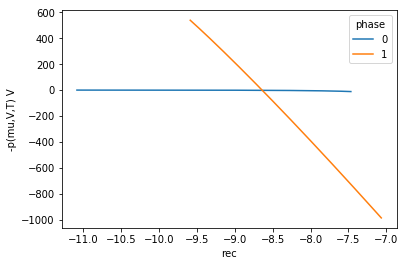

In [18]:
c2 = lnPi.CollectionPhases.from_dataarray(ref, da)

# add in spinodal/binodal data
c2.spinodals.from_dataarray(da)
c2.binodals.from_dataarray(da)

c2.xgce.omega().set_index(dict(rec='mu_0')).plot(hue='phase')

In [19]:
def make_omega_vs_mu_phase_plot(C,spin=None,bino=None,ax=None,ax_labels=True):
    if ax is None:
        fig,ax = plt.subplots()
        
    if spin is None:
        spin = C.spinodals.items.values()

    if bino is None:
        bino = C.binodals[0]
    
    for phase, g in C.xgce.omega().sortby('mu_0').groupby('phase'):
        ax.plot(g.mu_0, g)
#     for phase, g in C.Omegas_phaseIDs().reset_index().groupby('phase'):
#         g.plot('mu_0','Omega', ax=ax)
    colors = [l.get_color() for l in ax.lines]
    
    for phase, (s, c) in enumerate(zip(spin, colors)):
        s.xgce.omega().sel(phase=phase).pipe(lambda x: ax.plot(x.mu_0, x, marker='o', color=c))
    
    bino.xgce.omega().sel(phase=0).pipe(lambda x: ax.plot(x.mu_0, x, marker='s', color='k'))
#     for phase, (s, c) in enumerate(zip(spin, colors)):
#         s.Omegas_phaseIDs().xs(phase, level='phase').reset_index().plot('mu_0','Omega', marker='o', color=c, ax=ax)
#     bino.Omegas_phaseIDs().xs(0, level='phase').reset_index().plot('mu_0','Omega', marker='s', color='k', ax=ax)
    


    if ax_labels:
        ax.set_ylabel(r'$\Omega^{ex}$')
        ax.set_xlabel(r'$\mu$')
    

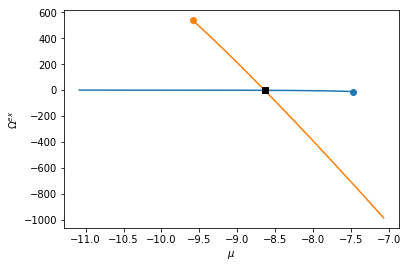

In [20]:
#plot
make_omega_vs_mu_phase_plot(c)

# bulk 065

In [21]:
base_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', mu=-4.453015418106743E+00,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))

builder_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_bulk, merge_kws=dict(efac=0.5), tag_phases=tag_phases2)

In [23]:
# initial estimate
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(ref.mu[0] - 4, ref.mu[0] + 4, 20), build_phases=builder_bulk.build_phases)
# c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.binodals(phase_ids=2, spinodals=spin, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.sort_by_mu()

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c, PhaseCreator.build_phases)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_bulk, build_phases=PhaseCreator.build_phases)


# better
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), build_phases=builder_bulk.build_phases)
c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.binodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.sort_by_mu()



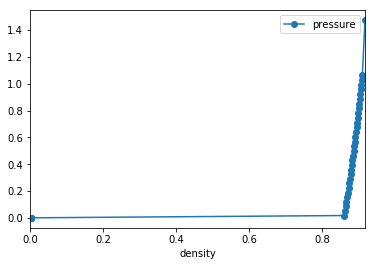

In [24]:
dens = c_bulk.xgce.density
pres = c_bulk.xgce.pressure()

# mask values
mask = pres.pipe(lambda x: x.max('phase') == x)

df = (
    xr.merge((dens, pres))
    .where(mask).max('phase')
    .to_dataframe()
)
    

df.plot('density','pressure',marker='o')

In [25]:
### p.assign_coords(n_0=p.n_0.assign_attrs(long_name='hello'))

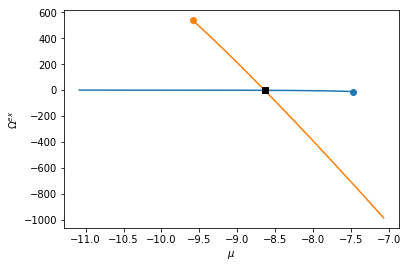

In [26]:
make_omega_vs_mu_phase_plot(c)

# confined

In [27]:
base_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',mu=-0.500000E+01,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phasecreator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_conf, merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

build_phases_conf = phasecreator_conf.build_phases





In [94]:
# initial estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(base_conf.mu[0] - 5, base_conf.mu[0] + 5, 20), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c_conf, build_phases_conf)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_conf, build_phases=build_phases_conf)

# better estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))




In [95]:
c_conf.spinodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.binodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.sort_by_mu()

(-5.14, -5.09)

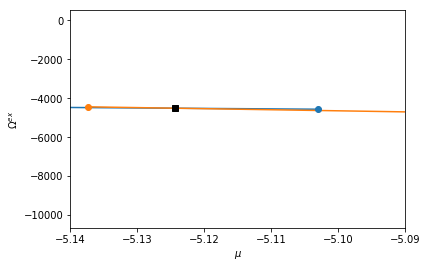

In [96]:
make_omega_vs_mu_phase_plot(c_conf)
plt.xlim(-5.14,-5.09)

In [100]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


# make isotherm

In [101]:
a = np.log(np.linspace(np.exp(-10), np.exp(c_conf.spinodals[1].mu[0]), 50, endpoint=False))

In [110]:
#a = np.linspace(-10,Cconf.spinodals[1].mu[0],200)
b = np.linspace(c_conf.spinodals[1].mu[0],c_conf.spinodals[0].mu[0],50)
c = np.linspace(c_conf.spinodals[0].mu[0],c_bulk.binodals[0].mu[0],50)
mus = np.concatenate((a,b,c))
#mus = c

In [111]:
print(c_conf.mu.max())
print(c_bulk.mu.max())

print(mus.max())

-4.178466796875
-2.8081126966781706
-4.453725936551545


In [112]:
cb = lnPi.core.CollectionPhases.from_mu([None],x=mus, ref=base_bulk, build_phases=builder_bulk.build_phases)
cc = lnPi.core.CollectionPhases.from_mu_iter(cb.mu, ref=base_conf, build_phases=build_phases_conf)

In [118]:
psat = c_bulk.binodals[0].xgce.pressure().sel(phase=0).values

In [119]:
p = cb.xgce.pressure().sel(phase=0) / psat

In [123]:
rho = cc.xgce.nave

In [141]:
iso = xr.merge((p.drop('volume'), rho.drop('volume'))).squeeze().to_dataframe().reset_index()

In [142]:
iso.head()

,phase,rec,mu_0,beta,pressure,nave
0,0,0,-10.000000,1.538462,0.000195,52.806189
1,0,1,-8.728236,1.538462,0.001377,774.982645
2,0,2,-8.186107,1.538462,0.003171,897.867008
3,0,3,-7.836514,1.538462,0.005430,941.621343
4,0,4,-7.577984,1.538462,0.008082,967.917146


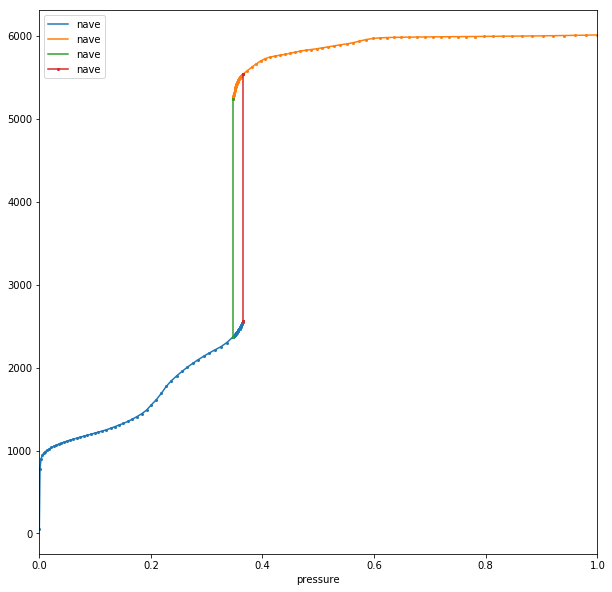

In [148]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax,marker='o', ms=2)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)

#plt.plot(df.pscaled,df.rho,'--', marker='o', ms=2)
# plt.gca().set_xlim(0,1.0)

(0.3, 0.5)

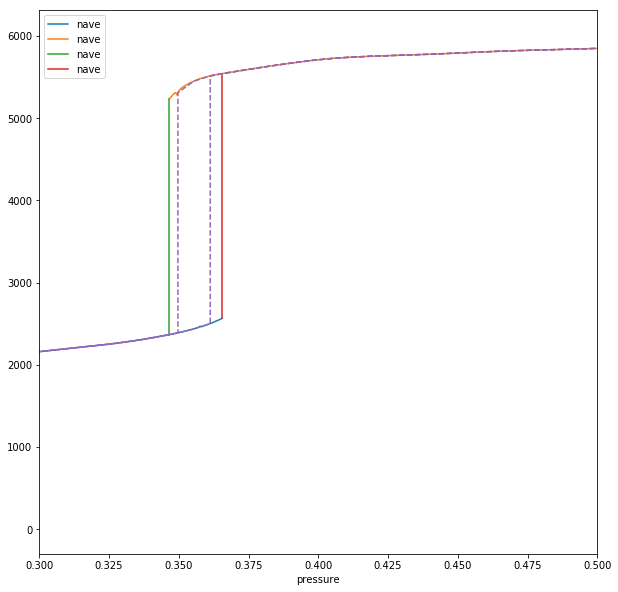

In [146]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax)

plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0.3,0.5)



In [74]:
# hard one